In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
df = pd.read_csv("full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


In [4]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [5]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [6]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [7]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [8]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [9]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [10]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)


In [11]:
print(len(cataract),len(normal))

594 500


In [12]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "C:/Users/MCA/Desktop/preprocess"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [13]:
dataset = create_dataset(cataract,1)

100%|██████████| 594/594 [00:07<00:00, 80.61it/s] 


In [14]:
len(dataset)

588

In [15]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:14<00:00, 34.40it/s]


In [16]:
len(dataset)

1088

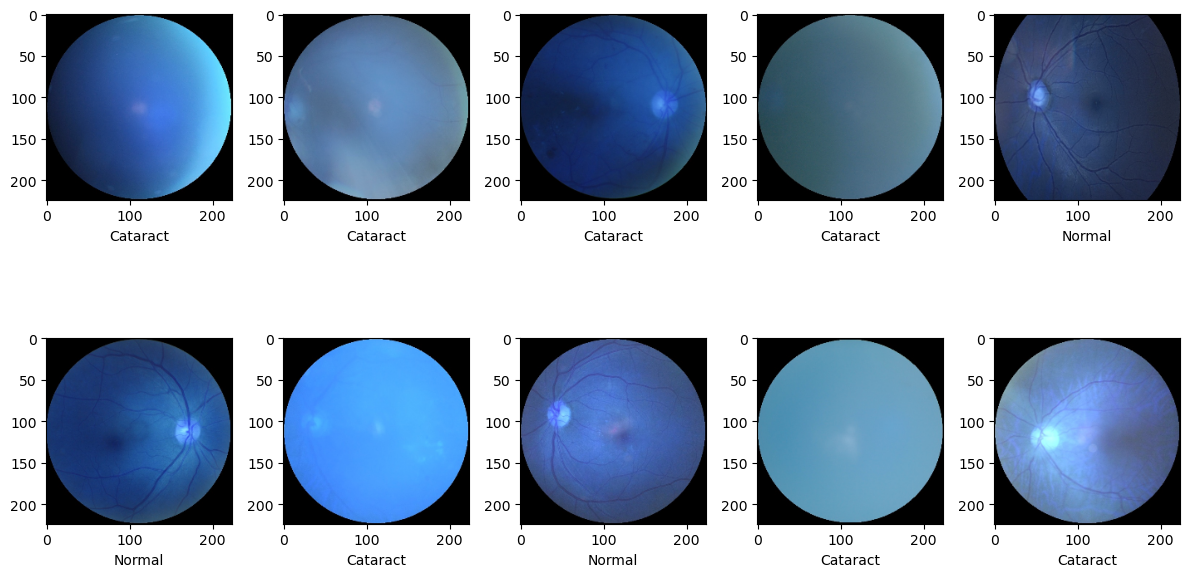

In [17]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

In [18]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [19]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [20]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

In [21]:
for layer in mobilenet.layers:
    layer.trainable = False

In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = Sequential()
model.add(mobilenet)
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 1)                 62721     
                                                                 
Total params: 2,320,705
Trainable params: 62,721
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("mobilenet.h5", monitor="val_acc", verbose=1, save_best_only=True, save_weights_only=False, period=1)
earlystop = EarlyStopping(monitor="val_acc", patience=5, verbose=1)

In [26]:
history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_test, y_test), verbose=1, callbacks=[checkpoint, earlystop])


Epoch 1/5
28/28 [==============================] - 25s 751ms/step - loss: 1.0718 - accuracy: 0.7805 - val_loss: 0.4886 - val_accuracy: 0.8624
Epoch 2/5
28/28 [==============================] - 19s 695ms/step - loss: 0.2363 - accuracy: 0.9253 - val_loss: 0.4622 - val_accuracy: 0.8624
Epoch 3/5
28/28 [==============================] - 19s 670ms/step - loss: 0.1648 - accuracy: 0.9391 - val_loss: 0.2703 - val_accuracy: 0.9312
Epoch 4/5
28/28 [==============================] - 22s 798ms/step - loss: 0.0846 - accuracy: 0.9701 - val_loss: 0.2531 - val_accuracy: 0.9358
Epoch 5/5
28/28 [==============================] - 21s 765ms/step - loss: 0.0449 - accuracy: 0.9828 - val_loss: 0.2221 - val_accuracy: 0.9633


In [27]:
loss, accuracy = model.evaluate(x_test, y_test)
print("loss:", loss)
print("Accuracy:", accuracy)

7/7 [==============================] - 4s 595ms/step - loss: 0.2221 - accuracy: 0.9633
loss: 0.22209040820598602
Accuracy: 0.963302731513977


In [28]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# Assuming 'model' is your Sequential model
raw_predictions = model.predict(x_test)
y_pred = np.argmax(raw_predictions, axis=1)

# Now you can use y_pred for further evaluation


7/7 [==============================] - 5s 550ms/step


In [29]:
accuracy_score(y_test,y_pred)

0.44036697247706424

In [30]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.44      1.00      0.61        96
           1       0.00      0.00      0.00       122

    accuracy                           0.44       218
   macro avg       0.22      0.50      0.31       218
weighted avg       0.19      0.44      0.27       218



C:\Users\MCA\Anaconda3\ana\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MCA\Anaconda3\ana\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MCA\Anaconda3\ana\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
pip install mlxtend


Note: you may need to restart the kernel to use updated packages.


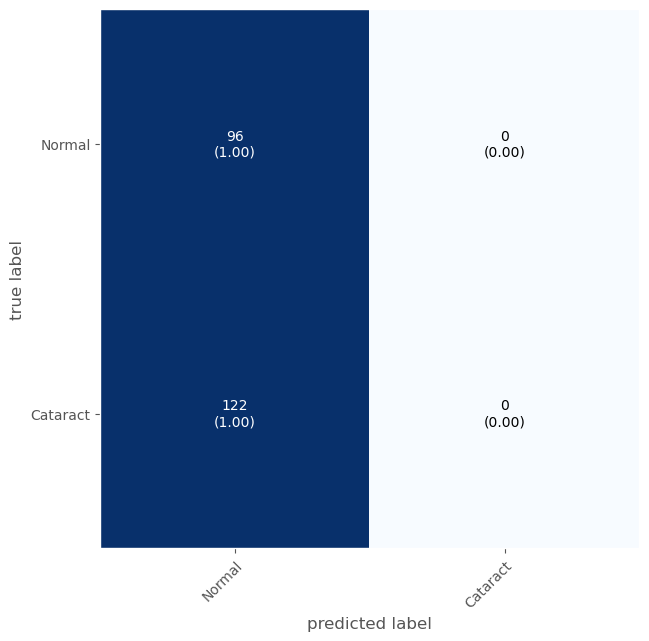

In [36]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True);

Length of epochs: 5
Length of history.history['accuracy']: 5
Length of history.history['val_accuracy']: 5


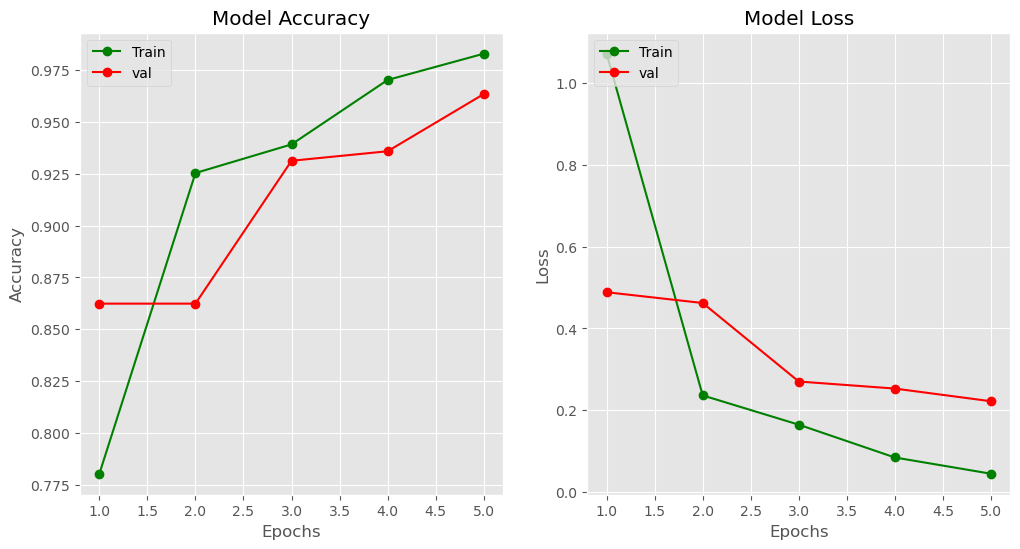

In [37]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
fig = plt.figure(figsize=(12, 6))

epochs = range(1, len(history.history['accuracy']) + 1)
print(f"Length of epochs: {len(epochs)}")

print(f"Length of history.history['accuracy']: {len(history.history['accuracy'])}")
print(f"Length of history.history['val_accuracy']: {len(history.history['val_accuracy'])}")

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "val"], loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "val"], loc="upper left")

plt.show()

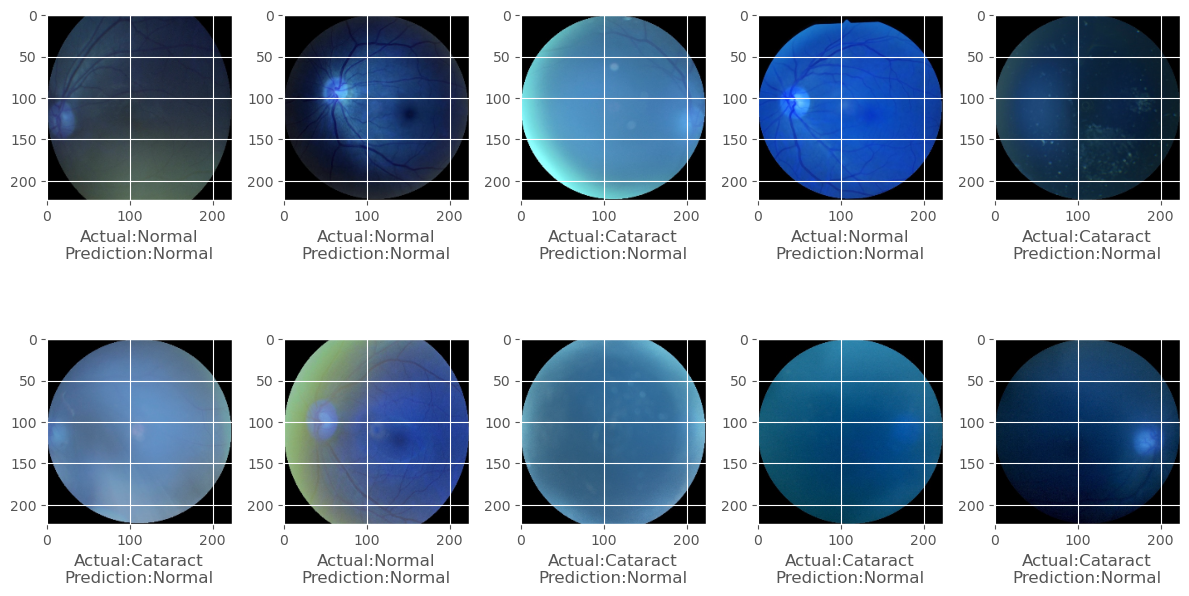

In [38]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 